# Denoising Score Matching(DSM) Notebook
- This notebook is for learning the DSM method and use this loss function to learn the distribution of the data.
- We will discuss the following topics:
    - One-step score matching
    - Score matching with different original distribution
    - Score matching in higher dimension
    - Score matching in a stochastic process
        - Ornstein-Uhlenbeck process
        - Sampling from Ornstein-Uhlenbeck process
    

# 0. Background Settings
This is the library we will use in this notebook

In [1]:
import jax
import jaxgeometry
import diffrax
import jax.random as jrandom
from jax import numpy as jnp
import flax
import flax.linen as nn
import optax
import numpy as np
import random
from flax.training import train_state
from functools import partial
import matplotlib.pyplot as plt

Random seed settings and key generator

In [2]:
seed = 0
rand_seed = random.randint(0, 1000000)
globe_key = jrandom.PRNGKey(rand_seed)
def key_gen():
    global globe_key
    new_key, subkey = jrandom.split(globe_key)
    globe_key = new_key
    return subkey


# 1. One-step score matching

In [3]:
def add_noise(key, x, sigma=0.1):
    key, subkey = jrandom.split(key)
    return x + sigma * jrandom.normal(subkey, x.shape)


class Onestep_score_MLP(nn.Module):
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(features=8)(x)
        x = nn.leaky_relu(x)
        x = nn.Dense(features=16)(x)
        x = nn.leaky_relu(x)
        x = nn.Dense(features=32)(x)
        x = nn.leaky_relu(x)
        x = nn.Dense(features=64)(x)
        x = nn.leaky_relu(x)
        x = nn.Dense(features=32)(x)
        x = nn.leaky_relu(x)
        x = nn.Dense(features=16)(x)
        x = nn.leaky_relu(x)
        x = nn.Dense(features=2)(x)
        x = nn.leaky_relu(x)
        
        return x
    
    

In [4]:
def init_train_state_onestep(key, model, x) ->train_state.TrainState:
    params = model.init(key, x)
    optimizer = optax.adam(learning_rate=1e-3)
    return train_state.TrainState.create(
        apply_fn=model.apply,
        params=params,
        tx=optimizer,
    )

@partial(jax.jit, static_argnums=(2,3))
def update_step(key, state, sigma, sample_size):
    key, subkey = jrandom.split(key)
    batch_x = jrandom.normal(subkey, (sample_size, 2))* 0.5 +1
    # batch_x = jrandom.uniform(subkey, (sample_size, 2)) * 8 - 4
    key, subkey = jrandom.split(key)
    batch_noised_x = add_noise(subkey, batch_x, sigma)
    def one_step_dsm(params):
        def mse(x, noised_x):
            pred = state.apply_fn(params, noised_x)
            true = (x - noised_x) / (sigma**2)
            return (jnp.linalg.norm(pred - true) ** 2) / 2
        return jnp.mean(jax.vmap(mse, in_axes=(0,0))(batch_x, batch_noised_x), axis=0)
    loss, grad = jax.value_and_grad(one_step_dsm)(state.params)
    state = state.apply_gradients(grads=grad)
    return state, loss

model = Onestep_score_MLP()
subkey = key_gen()
state = init_train_state_onestep(subkey, model, jnp.ones((1, 2)))
sigma = 0.1
sample_size = 500
for i in range(10000):
    subkey = key_gen()
    state, loss = update_step(subkey,state, sigma, sample_size)
    if i % 1000 == 0:
        print(loss)
    
    

100.12097
95.98389
97.39794
95.24602
95.38193
96.88955
99.2821
96.1528
98.79487
99.39949


### Plot the learned distribution on the 2D plane
The red arrows are gradients of the learned distribution and the original distribution is a 2D Gaussian distribution.

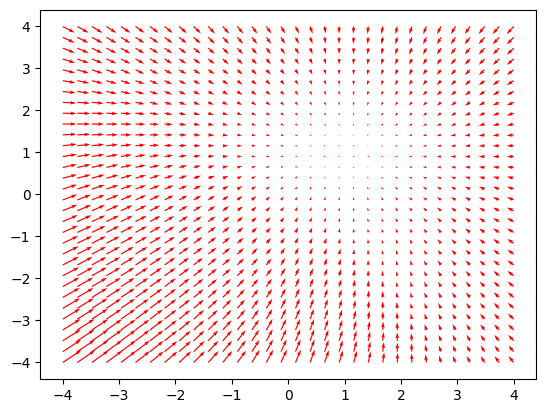

In [5]:
X, Y = jnp.meshgrid(jnp.linspace(-4, 4, 32), jnp.linspace(-4, 4, 32))
Z = jnp.stack([X.flatten(), Y.flatten()], axis=1)
result = jax.vmap(state.apply_fn, in_axes=(None, 0))(state.params, Z)
fig, ax = plt.subplots()
ax.quiver(Z[:, 0], Z[:, 1],result[:, 0], result[:, 1], color='r')
plt.show()

# 2. Score matching with different original distribution
People can use different original distribution to learn the distribution of the data. Here we will show the score matching method on different original distribution.

In [6]:
@partial(jax.jit, static_argnums=(2,3,4))
def update_step_mixture_gaussian(key, state, sigma, sample_size, num_mixture=2, mixture_weight=jnp.array([0.5, 0.5]), mixture_mean=jnp.array([-2, 2]), mixture_std=jnp.array([0.5, 0.5])):
    # test the sum of the mixture weight
    # assert jnp.sum(mixture_weight) == 1
    key, subkey = jrandom.split(key)
    compoent = jrandom.categorical(subkey, logits=jnp.log(mixture_weight), shape=(sample_size, 1))
    key, subkey = jrandom.split(key)
    batch_x = jrandom.normal(subkey, (sample_size, 2)) * mixture_std[compoent] + mixture_mean[compoent]
    # batch_x = jrandom.uniform(subkey, (sample_size, 2)) * 8 - 4
    key, subkey = jrandom.split(key)
    batch_noised_x = add_noise(subkey, batch_x, sigma)
    def one_step_dsm(params):
        def mse(x, noised_x):
            pred = state.apply_fn(params, noised_x)
            true = (x - noised_x) / (sigma**2)
            return (jnp.linalg.norm(pred - true) ** 2) / 2
        return jnp.mean(jax.vmap(mse, in_axes=(0,0))(batch_x, batch_noised_x), axis=0)
    loss, grad = jax.value_and_grad(one_step_dsm)(state.params)
    state = state.apply_gradients(grads=grad)
    return state, loss

In [7]:
model = Onestep_score_MLP()
subkey = key_gen()
state = init_train_state_onestep(subkey, model, jnp.ones((1, 2)))
sigma = 0.1
sample_size = 500
for i in range(10000):
    subkey = key_gen()
    state, loss = update_step_mixture_gaussian(subkey,state, sigma, sample_size, num_mixture=3, mixture_weight=jnp.array([0.8, 0.1, 0.1]), mixture_mean=jnp.array([-2, 2, 0]), mixture_std=jnp.array([0.5, 0.5, 0.5]))
    if i % 1000 == 0:
        print(loss)

98.682274
102.34243
99.27705
94.48813
96.30138
93.424385
101.18032
91.56914
93.41329
103.261345


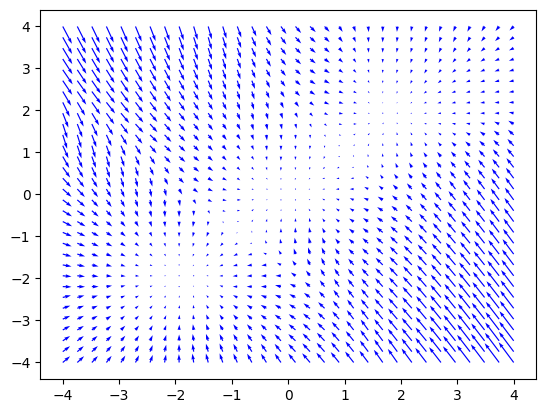

In [8]:
X, Y = jnp.meshgrid(jnp.linspace(-4, 4, 32), jnp.linspace(-4, 4, 32))
Z = jnp.stack([X.flatten(), Y.flatten()], axis=1)
result = jax.vmap(state.apply_fn, in_axes=(None, 0))(state.params, Z)
fig, ax = plt.subplots()
ax.quiver(Z[:, 0], Z[:, 1],result[:, 0], result[:, 1], color='b')
plt.show()

## 2.1 Sample given numbers of centers, std and mixture weight to generate the data

In [9]:
# sample the hyperparameters
def sample_hyperparameter(key, num_mixture=2):
    key, subkey = jrandom.split(key)
    mixture_weight = jrandom.dirichlet(subkey, jnp.ones(num_mixture))
    key, subkey = jrandom.split(key)
    mean_xs = jrandom.uniform(subkey, (num_mixture, 1)) * 10 - 5
    key, subkey = jrandom.split(key)
    mean_ys = jrandom.uniform(subkey, (num_mixture, 1)) * 10 - 5
    key, subkey = jrandom.split(key)
    stds = jrandom.uniform(subkey, (num_mixture, 2)) *1 + 0.5
    means = jnp.stack([mean_xs, mean_ys], axis=-1)
    return mixture_weight, means, stds, key

def sample_mixture_gaussian(key,num_mixture, sample_size, mixture_weight=None, means=None, stds=None):
    key, subkey = jrandom.split(key)
    compoent = jrandom.categorical(subkey, logits=jnp.log(mixture_weight), shape=(sample_size, 1))
    key, subkey = jrandom.split(key)
    stds = jnp.reshape(stds[compoent], (sample_size, 2))
    means = jnp.reshape(means[compoent], (sample_size, 2))
    print(stds)
    
    batch_x = jax.vmap(lambda mean, std: jnp.multiply(jrandom.normal(subkey, (2,)), std) + mean, in_axes=(0,0))(means, stds)
    return batch_x, mixture_weight, means, stds, key

@partial(jax.jit, static_argnums=(2,3,4))
def update_step_MG_random(key, state, sigma, sample_size, num_mixture, mixture_weight=jnp.array([0.5, 0.5]), means=jnp.array([[-2, 2], [2, -2]]), stds=jnp.array([[0.5, 0.5], [0.5, 0.5]])):
    batch_x, mixture_weight, means, stds, key = sample_mixture_gaussian(key,num_mixture, sample_size, mixture_weight, means, stds)
    key, subkey = jrandom.split(key)
    batch_noised_x = add_noise(subkey, batch_x, sigma)
    def one_step_dsm(params):
        def mse(x, noised_x):
            pred = state.apply_fn(params, noised_x)
            true = (x - noised_x) / (sigma**2)
            return (jnp.linalg.norm(pred - true) ** 2) / 2
        return jnp.mean(jax.vmap(mse, in_axes=(0,0))(batch_x, batch_noised_x), axis=0)
    loss, grad = jax.value_and_grad(one_step_dsm)(state.params)
    state = state.apply_gradients(grads=grad)
    return state, loss

model = Onestep_score_MLP()
subkey = key_gen()
state = init_train_state_onestep(subkey, model, jnp.ones((1, 2)))
sigma = 0.1
sample_size = 500
num_mixture = 2
mixture_weight, means, stds, subkey = sample_hyperparameter(subkey, num_mixture)
globe_key = subkey

for i in range(10000):
    subkey = key_gen()
    state, loss = update_step_MG_random(subkey,state, sigma, sample_size, num_mixture, mixture_weight, means, stds)
    if i % 1000 == 0:
        print(loss)
    
print("Mixture weight: ", mixture_weight)
print("Mixture means: ", means)
print("Mixture stds: ", stds)
print("mixture covariance: ", jax.vmap(lambda std: jnp.diag(std**2), in_axes=(0))(stds))


Traced<ShapedArray(float32[500,2])>with<DynamicJaxprTrace(level=1/0)>
95.4994
98.161285
101.396675
103.239395
98.27906
99.14196
93.77153
99.47851
106.890335
93.350975
Mixture weight:  [0.4436154 0.5563846]
Mixture means:  [[[ 2.9921412 -3.4182346]]

 [[-2.3876643 -3.5548854]]]
Mixture stds:  [[0.5863457 1.1208977]
 [0.5933809 1.4869359]]
mixture covariance:  [[[0.34380126 0.        ]
  [0.         1.2564116 ]]

 [[0.35210094 0.        ]
  [0.         2.2109783 ]]]


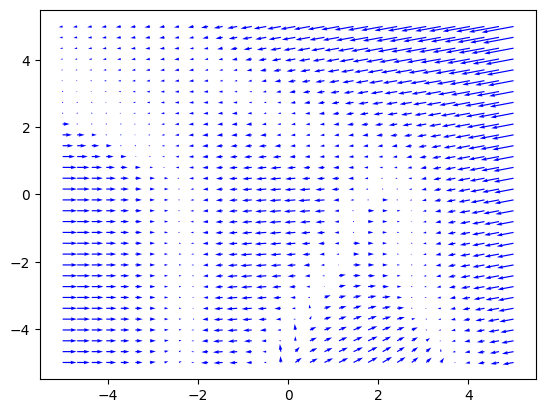

In [10]:
X, Y = jnp.meshgrid(jnp.linspace(-5, 5, 32), jnp.linspace(-5, 5, 32))
Z = jnp.stack([X.flatten(), Y.flatten()], axis=1)
result = jax.vmap(state.apply_fn, in_axes=(None, 0))(state.params, Z)
fig, ax = plt.subplots()
ax.quiver(Z[:, 0], Z[:, 1],result[:, 0], result[:, 1], color='b')
plt.show()


## 2.2 Sample mixture gaussian that centers are on the circle

In [11]:
class MLP_for_circle(nn.Module):
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(features=8)(x)
        x = nn.leaky_relu(x)
        x = nn.Dense(features=16)(x)
        x = nn.leaky_relu(x)
        x = nn.Dense(features=32)(x)
        x = nn.leaky_relu(x)
        x = nn.Dense(features=64)(x)
        x = nn.leaky_relu(x)
        x = nn.Dense(features=64)(x)
        x = nn.leaky_relu(x)
        x = nn.Dense(features=32)(x)
        x = nn.leaky_relu(x)
        x = nn.Dense(features=16)(x)
        x = nn.leaky_relu(x)
        x = nn.Dense(features=2)(x)
        x = nn.leaky_relu(x)
        
        return x

In [12]:
@partial(jax.jit, static_argnums=(0,1))
def circle_points(num_points, radius):
    angles = jnp.linspace(0, 2*jnp.pi, num_points+1)[:-1]
    print(angles)
    x = radius * jnp.cos(angles)
    y = radius * jnp.sin(angles)
    return jnp.stack([x, y], axis=-1)

@partial(jax.jit, static_argnums=(2,3,4,5))
def update_step_GM_circle(key, state, sigma, sample_size, num_mixture, radius=2):
    means = circle_points(num_mixture, radius)
    mixture_weight = jnp.ones(num_mixture) / num_mixture
    key, subkey = jrandom.split(key)
    compoent = jrandom.categorical(subkey, logits=jnp.log(mixture_weight), shape=(sample_size, 1))
    keys = jrandom.split(key, sample_size)
    # keys = keys[:,0]
    # keys = keys.reshape((sample_size, -1))
    batched_x = jax.vmap(lambda mean, single_key: jrandom.normal(single_key, (2,)) * 0.5 + mean, in_axes=(0, 0))(means[compoent], keys )
    key, subkey = jrandom.split(key)
    batch_noised_x = add_noise(subkey, batched_x, sigma)
    def one_step_dsm(params):
        def mse(x, noised_x):
            pred = state.apply_fn(params, noised_x)
            true = (x - noised_x) / (sigma**2)
            return (jnp.linalg.norm(pred - true) ** 2) / 2
        return jnp.mean(jax.vmap(mse, in_axes=(0,0))(batched_x, batch_noised_x), axis=0)
    
    loss, grad = jax.value_and_grad(one_step_dsm)(state.params)
    state = state.apply_gradients(grads=grad)
    return state, loss

model = MLP_for_circle()
subkey = key_gen()
state = init_train_state_onestep(subkey, model, jnp.ones((1, 2)))
sigma = 0.1
sample_size = 800
num_mixture = 8
radius = 2
for i in range(10000):
    subkey = key_gen()
    state, loss = update_step_GM_circle(subkey,state, sigma, sample_size, num_mixture, radius)
    if i % 1000 == 0:
        print(loss)

Traced<ShapedArray(float32[8])>with<DynamicJaxprTrace(level=2/0)>
101.320786
101.04182
104.17171
93.729256
104.43338
101.596924
101.697426
97.52233
96.85259
99.838776


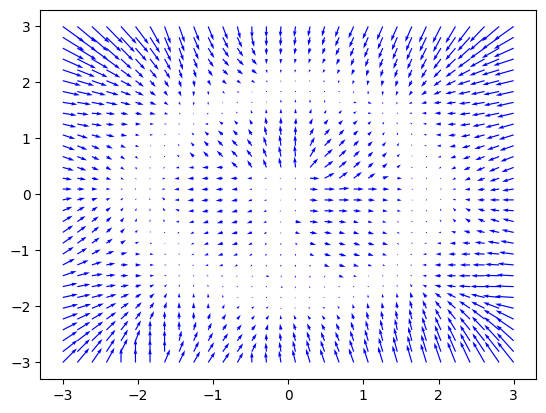

In [13]:
X, Y = jnp.meshgrid(jnp.linspace(-3, 3, 32), jnp.linspace(-3, 3, 32))
Z = jnp.stack([X.flatten(), Y.flatten()], axis=1)
result = jax.vmap(state.apply_fn, in_axes=(None, 0))(state.params, Z)
fig, ax = plt.subplots()
ax.quiver(Z[:, 0], Z[:, 1],result[:, 0], result[:, 1], color='b')
plt.show()

Traced<ShapedArray(float32[8])>with<DynamicJaxprTrace(level=1/0)>
[[ 5.0000000e+00  0.0000000e+00]
 [ 3.5355339e+00  3.5355341e+00]
 [-2.1855695e-07  5.0000000e+00]
 [-3.5355339e+00  3.5355341e+00]
 [-5.0000000e+00 -4.3711390e-07]
 [-3.5355334e+00 -3.5355344e+00]
 [ 5.9624405e-08 -5.0000000e+00]
 [ 3.5355351e+00 -3.5355327e+00]]


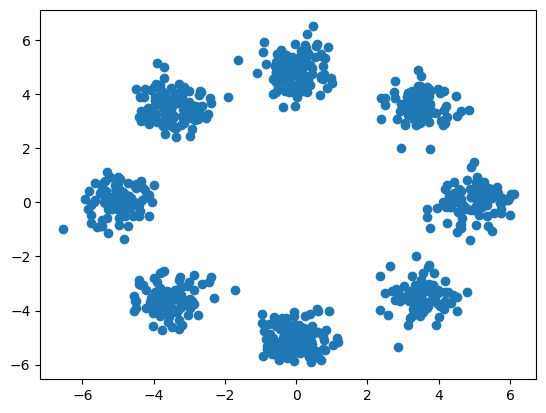

In [14]:
centers = circle_points(8, 5)
print(centers)
mixture_weight = jnp.ones(8) / 8
key, subkey = jrandom.split(key_gen())

compont = jrandom.categorical(subkey, logits=jnp.log(mixture_weight), shape=(800, 1))

key, subkey = jrandom.split(key)
keys = jrandom.split(subkey, 800)
samples = jax.vmap(lambda center, key: jrandom.normal(key, (2,)) * 0.5 + center, in_axes=(0, 0))(centers[compont], keys)
plt.scatter(samples[:, :, 0], samples[:, :, 1])

## 2.3 Compare the learned score with the true score of a 2D Gaussian distribution

We sample the score of a given multivariate gaussian distribution, then using the model to learn the score.
Finally we compare the learned score with the true score. The tested distribution is a 2D Gaussian distribution, where the mean is [0, 0] and the covariance matrix is [[1, 0.5], [0.5, 2]]

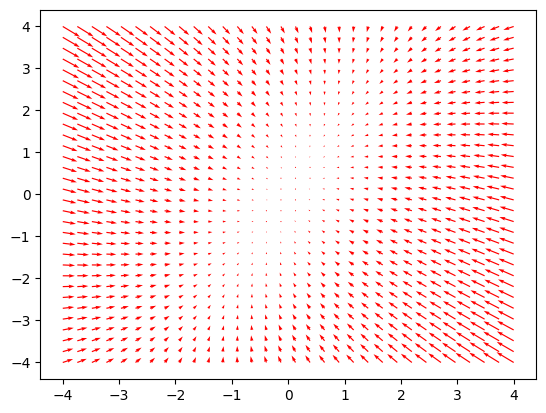

In [15]:
from jax.scipy.linalg import solve
from jax import grad, vmap

def multivariate_gaussian_pdf(x, mu, sigma):
    d = len(mu)
    x_centered = x - mu
    return (
        (2 * jnp.pi) ** (-d / 2)
        * jnp.linalg.det(sigma) ** (-1 / 2)
        * jnp.exp(-0.5 * x_centered.T @ solve(sigma, x_centered))
    )

def multivariate_gaussian_score(x, mu, sigma):
    log_pdf = lambda x: jnp.log(multivariate_gaussian_pdf(x, mu, sigma))
    return grad(log_pdf)(x)

# 示例使用
mu = jnp.array([0.0, 0.0])
sigma = jnp.array([[1.0, 0.5], [0.5, 2.0]])
x = jnp.array([[0.5, 1.0], [1.0, 1.5], [1.5, 2.0]])

score_func = vmap(multivariate_gaussian_score, in_axes=(0, None, None))
scores = score_func(x, mu, sigma)

x,y = jnp.meshgrid(jnp.linspace(-4, 4, 32), jnp.linspace(-4, 4, 32))
Z = jnp.stack([x.flatten(), y.flatten()], axis=1)
result = jax.vmap(lambda x: multivariate_gaussian_score(x, mu, sigma), in_axes=(0))(Z)
fig, ax = plt.subplots()
ax.quiver(Z[:, 0], Z[:, 1],result[:, 0], result[:, 1], color='r')

In [16]:
@partial(jax.jit, static_argnums=(2,3))
def update_step_multi_gaussian(key, state, sigma, sample_size, mu, Sigma):
    key, subkey = jrandom.split(key)
    batch_x = jrandom.multivariate_normal(subkey, mu, Sigma, (sample_size,))
    key, subkey = jrandom.split(key)
    batch_noised_x = add_noise(subkey, batch_x, sigma)
    def one_step_dsm(params):
        def mse(x, noised_x):
            pred = state.apply_fn(params, noised_x)
            true = (x - noised_x) / (sigma**2)
            return (jnp.linalg.norm(pred - true) ** 2) / 2
        return jnp.mean(jax.vmap(mse, in_axes=(0,0))(batch_x, batch_noised_x), axis=0)
    loss, grad = jax.value_and_grad(one_step_dsm)(state.params)
    state = state.apply_gradients(grads=grad)
    return state, loss

model = Onestep_score_MLP()
subkey = key_gen()
state = init_train_state_onestep(subkey, model, jnp.ones((1, 2)))
sigma = 0.1
sample_size = 500
mu = jnp.array([0.0, 0.0])
Sigma = jnp.array([[1.0, 0.5], [0.5, 2.0]])
for i in range(10000):
    subkey = key_gen()
    state, loss = update_step_multi_gaussian(subkey,state, sigma, sample_size, mu, Sigma)
    if i % 1000 == 0:
        print(loss)

99.36216
98.022575
96.36405
92.23464
101.01373
103.10099
96.833336
98.69152
92.13166
93.68996


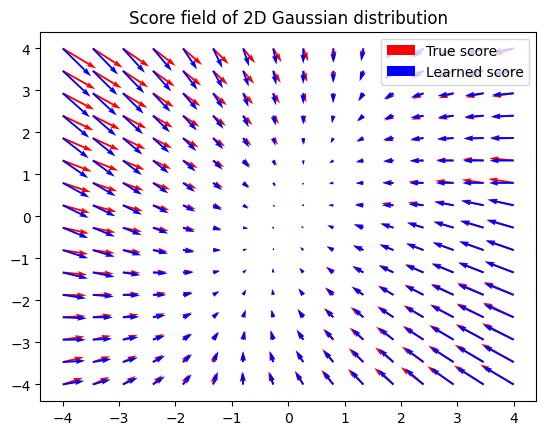

In [17]:
x,y = jnp.meshgrid(jnp.linspace(-4, 4, 16), jnp.linspace(-4, 4, 16))
Z = jnp.stack([x.flatten(), y.flatten()], axis=1)
result = jax.vmap(lambda x: multivariate_gaussian_score(x, mu, Sigma), in_axes=(0))(Z)
result_pred = jax.vmap(state.apply_fn, in_axes=(None, 0))(state.params, Z)
fig, ax = plt.subplots()
ax.quiver(Z[:, 0], Z[:, 1],result[:, 0], result[:, 1], color='r')
ax.quiver(Z[:, 0], Z[:, 1],result_pred[:, 0], result_pred[:, 1], color='b')
ax.legend(["True score", "Learned score"])
ax.set_title("Score field of 2D Gaussian distribution")
plt.show()

## 3. Do the DSM on the 3D Gaussian distribution

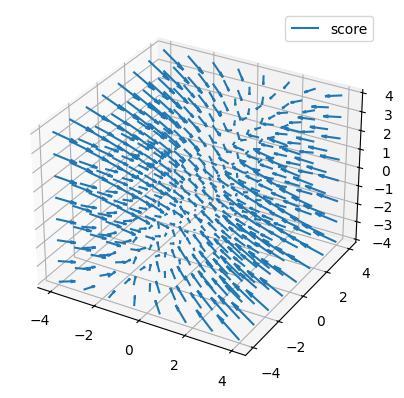

In [18]:
# 3D Gaussian distribution
def multivariate_gaussian_pdf(x, mu, sigma):
    d = len(mu)
    x_centered = x - mu
    return (
        (2 * jnp.pi) ** (-d / 2)
        * jnp.linalg.det(sigma) ** (-1 / 2)
        * jnp.exp(-0.5 * x_centered.T @ solve(sigma, x_centered))
    )

def multivariate_gaussian_score(x, mu, sigma):
    log_pdf = lambda x: jnp.log(multivariate_gaussian_pdf(x, mu, sigma))
    return grad(log_pdf)(x)

# 示例使用
mu = jnp.array([0.0, 0.0, 0.0])
sigma = jnp.array([[1.0, 0.5, 0.5], [0.5, 2.0, 0.5], [0.5, 0.5, 3.0]])
x = jnp.array([[0.5, 1.0, 1.5], [1.0, 1.5, 2.0], [1.5, 2.0, 2.5]])

score_func = vmap(multivariate_gaussian_score, in_axes=(0, None, None))
scores = score_func(x, mu, sigma)

x,y,z = jnp.meshgrid(jnp.linspace(-4, 4, 8), jnp.linspace(-4, 4, 8), jnp.linspace(-4, 4, 8))
Z = jnp.stack([x.flatten(), y.flatten(), z.flatten()], axis=1)
result = jax.vmap(lambda x: multivariate_gaussian_score(x, mu, sigma), in_axes=(0))(Z)
ax = plt.figure().add_subplot(projection='3d')
ax.quiver(Z[:, 0], Z[:, 1], Z[:, 2], result[:, 0], result[:, 1], result[:, 2], length=0.2)
ax.legend(["score"])
plt.show()

We can add the dim parameter to the MLP model to learn the 3D distribution.

In [19]:
class Onestep_score_MLP(nn.Module):
    @nn.compact
    def __call__(self, x, dim):
        x = nn.Dense(features=8)(x)
        x = nn.leaky_relu(x)
        x = nn.Dense(features=16)(x)
        x = nn.leaky_relu(x)
        x = nn.Dense(features=32)(x)
        x = nn.leaky_relu(x)
        x = nn.Dense(features=64)(x)
        x = nn.leaky_relu(x)
        x = nn.Dense(features=32)(x)
        x = nn.leaky_relu(x)
        x = nn.Dense(features=16)(x)
        x = nn.leaky_relu(x)
        x = nn.Dense(features=dim)(x)
        x = nn.leaky_relu(x)
        
        return x
    
# the init_train_state_onestep function should be modified to add the dim parameter
def init_train_state_onestep(key, model, x, dim) ->train_state.TrainState:
    params = model.init(key, x, dim=dim)
    optimizer = optax.adam(learning_rate=1e-3)
    return train_state.TrainState.create(
        apply_fn=model.apply,
        params=params,
        tx=optimizer,
    )

In [20]:
@partial(jax.jit, static_argnums=(2,3,6))
def update_step_multi_gaussian(key, state, sigma, sample_size, mu, Sigma,dim):
    key, subkey = jrandom.split(key)
    batch_x = jrandom.multivariate_normal(subkey, mu, Sigma, (sample_size,))
    key, subkey = jrandom.split(key)
    batch_noised_x = add_noise(subkey, batch_x, sigma)
    def one_step_dsm(params):
        def mse(x, noised_x):
            pred = state.apply_fn(params, noised_x, dim)
            true = (x - noised_x) / (sigma**2)
            return (jnp.linalg.norm(pred - true) ** 2) / 2
        return jnp.mean(jax.vmap(mse, in_axes=(0,0))(batch_x, batch_noised_x), axis=0)
    loss, grad = jax.value_and_grad(one_step_dsm)(state.params)
    state = state.apply_gradients(grads=grad)
    return state, loss

model = Onestep_score_MLP()
subkey = key_gen()
state = init_train_state_onestep(subkey, model, jnp.ones((1, 3)), dim=3)
sigma = 0.1
sample_size = 500
mu = jnp.array([0.0, 0.0, 0.0])
Sigma = jnp.array([[1.0, 0.5, 0.5], [0.5, 2.0, 0.5], [0.5, 0.5, 3.0]])
for i in range(20000):
    subkey = key_gen()
    state, loss = update_step_multi_gaussian(subkey,state, sigma, sample_size, mu, Sigma, 3)
    if i % 1000 == 0:
        print(loss)

148.60901
155.76973
150.14429
156.6492
156.57603
151.19656
144.34467
157.43594
156.21338
147.23279
141.56528
150.94313
145.28575
146.68933
154.55966
146.38553
145.9902
136.87598
156.282
149.14272


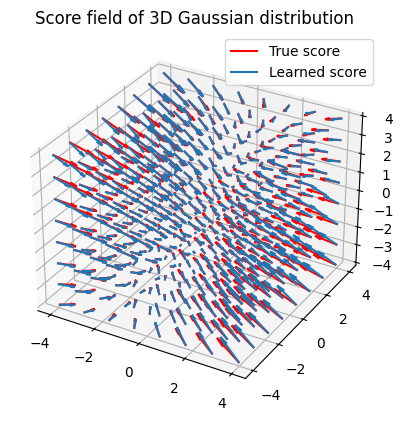

In [21]:
x,y,z = jnp.meshgrid(jnp.linspace(-4, 4, 8), jnp.linspace(-4, 4, 8), jnp.linspace(-4, 4, 8))
Z = jnp.stack([x.flatten(), y.flatten(), z.flatten()], axis=1)
result = jax.vmap(lambda x: multivariate_gaussian_score(x, mu, Sigma), in_axes=(0))(Z)
result_pred = jax.vmap(lambda x: state.apply_fn(state.params, x, 3), in_axes=(0))(Z)
ax = plt.figure().add_subplot(projection='3d')
ax.quiver(Z[:, 0], Z[:, 1], Z[:, 2], result[:, 0], result[:, 1], result[:, 2], length=0.2, color='r')
ax.quiver(Z[:, 0], Z[:, 1], Z[:, 2], result_pred[:, 0], result_pred[:, 1], result_pred[:, 2], length=0.2)
ax.legend(["True score", "Learned score"])
ax.set_title("Score field of 3D Gaussian distribution")
plt.show()

## 4. Score matching in a stochastic process

We will simulate the stochastic process in a Stochastic Differential Equation perspective, first we will simulate the Brownian Process and then we will simulate the Ornstein-Uhlenbeck process.


In [22]:
import jax
import jaxgeometry
import diffrax
import jax.random as jrandom
from jax import numpy as jnp
import flax
import flax.linen as nn
import optax
import numpy as np
import random
from flax.training import train_state
from functools import partial
import matplotlib.pyplot as plt

### 4.1 Ornstein-Uhlenbeck process in Noise adding perspective

In [23]:
# generate sigmas for the OU process, in a geometric sequence. Settings for the OU process
time_steps = 10 # the time steps for the OU process
sigma_start = 0.1 # the noise level at the first time step
sigma_end = 0.01 # the noise level at the last time step
sigmas = jnp.geomspace(sigma_start, sigma_end, time_steps) # generate a geometric sequence of noise levels

# define the model for fitting the score of the OU process
class ResidualBlock(nn.Module):
    features: int

    @nn.compact
    def __call__(self, x):
        residual = x
        x = nn.LayerNorm()(x)
        x = nn.Dense(features=self.features)(x)
        x = nn.swish(x)
        x = nn.Dense(features=x.shape[-1])(x)
        return x + residual

class SelfAttention(nn.Module):
    num_heads: int = 4

    @nn.compact
    def __call__(self, x):
        b, d = x.shape
        assert d % self.num_heads == 0, "Features must be divisible by num_heads"
        
        qkv = nn.Dense(features=d * 3, use_bias=False)(x)
        q, k, v = jnp.split(qkv, 3, axis=-1)
        q = q.reshape(b, self.num_heads, -1)
        k = k.reshape(b, self.num_heads, -1)
        v = v.reshape(b, self.num_heads, -1)

        attention = jnp.einsum('bhd,bHd->bhH', q, k) / jnp.sqrt(d // self.num_heads)
        attention = nn.softmax(attention, axis=-1)
        
        output = jnp.einsum('bhH,bHd->bhd', attention, v)
        output = output.reshape(b, d)
        return output


class AdvancedScoreNet(nn.Module):
    hidden_dims: tuple = (64, 128, 256, 128, 64)

    @nn.compact
    def __call__(self, x, t, dim):
        t = jnp.broadcast_to(t, x.shape)
        x = jnp.concatenate([x, t], axis=-1)
        x = nn.Dense(features=self.hidden_dims[0])(x)
        x = nn.swish(x)
        for hidden_dim in self.hidden_dims[1:]:
            x = nn.Dense(features=hidden_dim)(x)
            x = nn.swish(x)
        x = nn.Dense(features=dim)(x)
        return x
            
        




First we generate the training data obeying the Brownian Process

In [37]:
# generate the training data obeying the Brownian Process
def gen_brownian_data(key, batch_size, time_steps, dim):
    
    x0 = jnp.zeros((batch_size, dim))
    keys = jrandom.split(key, batch_size * time_steps)
    keys = keys.reshape((batch_size, time_steps, -1))
    
    sigma_start = 0.5
    sigma_end = 0.1
    sigmas = jnp.geomspace(sigma_start, sigma_end, time_steps)
    
    def add_noise_one_step(x, key, sigma):
        return x + jrandom.normal(key, x.shape) * sigma
    x_list = []
    x_list.append(x0)
    for i in range(time_steps):
        key = keys[:, i]
        x0 = jax.vmap(add_noise_one_step, in_axes=(0, 0, None))(x0, key, sigmas[i])
        x_list.append(x0)
    key = keys[-1, -1, :]
    
    return jnp.stack(x_list, axis=1), key # shape: (batch_size, time_steps, dim)
    
time_steps = 200
training_data, key = gen_brownian_data(key_gen(), 10, time_steps, 2)
globe_key = key

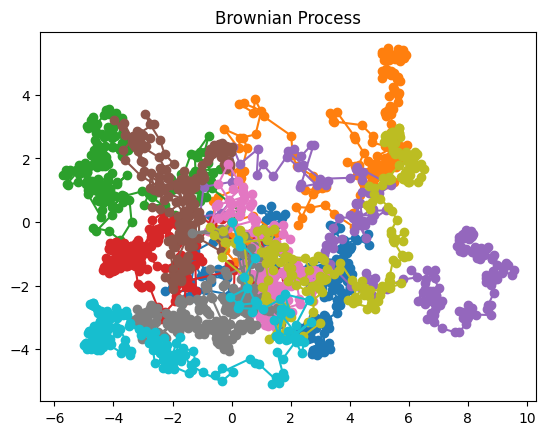

In [38]:
def plot_trajectory(trajectory, dim):
    fig, ax = plt.subplots()
    for i in range(trajectory.shape[0]):
        ax.plot(trajectory[i, :, 0], trajectory[i, :, 1], marker='o')
    ax.set_title("Brownian Process")
    plt.show()
    
plot_trajectory(training_data, 2)
    


The Brownian Motion (Wiener Process) can be represented by $dX(t) = \sigma dW(t) $, and the Euler-Maruyama can be used to solve the Brownian Motion. The One step of Euler-Maruyama can be represented by $X(t + \Delta t) = X(t) + \sigma \Delta W(t)$, where $\Delta W(t) = W(t + \Delta t) - W(t)$, and $\Delta W(t) \sim N(0, \Delta t)$

In [39]:
# Define the Euler-Maruyama method to solve the Brownian Motion
class EulerMaruyama:
    def __init__(self, x0, dim, batch_size,sigma, time_steps, key):
        self.dim = dim
        self.sigma = sigma
        self.time_steps = time_steps
        self.dt = 1.0 / time_steps
        self.key = key
        self.x0 = x0
        self.batch_size = batch_size
    def renew_key(self, batch_size):
        self.key, subkey = jrandom.split(self.key)
        return jrandom.split(subkey, batch_size)
    def sample_dW(self, key):
        return jrandom.normal(key, (self.dim,)) * jnp.sqrt(self.dt)

    def one_step(self, x, key):
        dW = self.sample_dW(key)
        x = x + self.sigma * dW
        return x


    def solve(self):
        x = self.x0
        x_list = []
        x_list.append(x)
        for i in range(self.time_steps):
            key = self.renew_key(self.batch_size)
            xs = jax.vmap(self.one_step, in_axes=(0, 0))(x, key)
            x = xs
            x_list.append(x)
        return jnp.stack(x_list, axis=1)   
    def return_key(self):
        return self.key

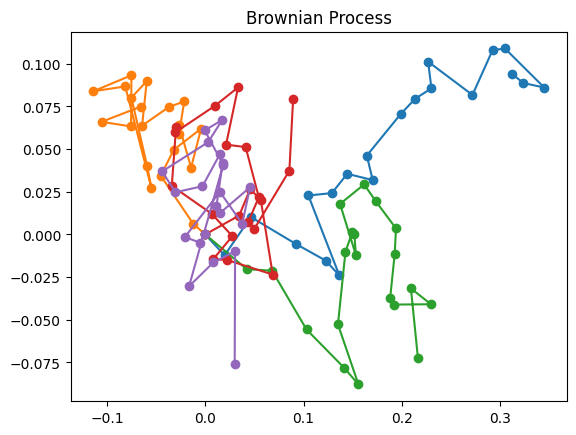

In [42]:

# Generate the training data using the Euler-Maruyama method
sigma = 0.1
time_steps = 20
batch_size = 5
dim = 2
x0 = jnp.zeros((batch_size, dim))
key = key_gen()
em = EulerMaruyama(x0, dim, batch_size, sigma, time_steps, key)
key = em.return_key()
globe_key = key
training_data = em.solve()
plot_trajectory(training_data, dim)

In [43]:
print(jnp.linspace(0, 1, time_steps + 1))
print(training_data.shape)
x_original = training_data[:, :-1, :]
x_noised = training_data[:, 1:, :]
print(x_original.shape)
print(x_noised.shape)
ts = jnp.linspace(0, 1, time_steps + 1)
ts = ts[1:]
print(ts.shape)

[0.         0.05       0.1        0.15       0.2        0.25
 0.3        0.35       0.4        0.45000002 0.5        0.55
 0.6        0.65000004 0.7        0.75       0.8        0.85
 0.90000004 0.95       1.        ]
(5, 21, 2)
(5, 20, 2)
(5, 20, 2)
(20,)


In [44]:
# init the model and the training state
def init_train_state_Brownian(key, model, x, t, dim) ->train_state.TrainState:
    params = model.init(key, x, t, dim=dim)
    optimizer = optax.adam(learning_rate=1e-3)
    return train_state.TrainState.create(
        apply_fn=model.apply,
        params=params,
        tx=optimizer,
    )

model = AdvancedScoreNet()
subkey = key_gen()
state = init_train_state_Brownian(subkey, model, jnp.zeros(dim,), 0, dim)
@partial(jax.jit, static_argnums=(2,3,4,5))
def update_step_Brownian(key, state, sigma, batch_size, time_steps, dim):
    # key, subkey = jrandom.split(key)
    em = EulerMaruyama(jnp.zeros((batch_size, dim)), dim, batch_size, sigma, time_steps, key)
    key = em.return_key()
    x = em.solve()
    t = jnp.array([0.0])
    ts = jnp.linspace(0, 1, time_steps + 1)
    ts = ts[1:]
    x_original = x[:, :-1, :]
    x0s = x[:, 0, :]
    x0s = jnp.expand_dims(x0s, axis=1)
    x0s = jnp.repeat(x0s, time_steps, axis=1)
    print(x0s.shape)
    x_noised = x[:, 1:, :]

    def total_loss(params):
        
        def one_step_dsm(x_original, x_noised, t):
            def mse(x_original, x_noised, t):
                print("Now in mse")
                print("x_original: ", x_original.shape)
                print(x_original)
                print("x_noised: ", x_noised.shape)
                print(x_noised)
                print("t: ", t.shape)
                print(t)
                pred = state.apply_fn(params, x_noised, t, dim)
                true = (x_original - x_noised) / (sigma**2)
                return (jnp.linalg.norm(pred - true) ** 2) / 2
            print("Now in one_step_dsm")
            print("x_original: ", x_original.shape)
            print("x_noised: ", x_noised.shape)
            print("t: ", t.shape)
            return jnp.sum(jax.vmap(mse, in_axes=(0, 0, None))(x_original, x_noised, t), axis=0)
        
        
        return jnp.sum(jax.vmap(one_step_dsm, in_axes=(1, 1, 0))(x0s, x_noised, ts), axis=0)
    loss, grad = jax.value_and_grad(total_loss)(state.params)
    state = state.apply_gradients(grads=grad)
    return state, loss, key

Given the training data, we can use the model to learn the score of the Brownian Motion

In [45]:
sigma = 0.1
time_steps = 100
batch_size = 100
dim = 2
for i in range(1000):
    subkey = key_gen()
    state, loss, key = update_step_Brownian(subkey, state, sigma, batch_size, time_steps, dim)
    globe_key = key
    if i % 100 == 0:
        print(loss)

(100, 100, 2)
Now in one_step_dsm
x_original:  (100, 2)
x_noised:  (100, 2)
t:  ()
Now in mse
x_original:  (2,)
Traced<ShapedArray(float32[2])>with<BatchTrace(level=5/0)> with
  val = Traced<ShapedArray(float32[100,2])>with<BatchTrace(level=4/0)> with
    val = Traced<ShapedArray(float32[100,100,2])>with<DynamicJaxprTrace(level=1/0)>
    batch_dim = 1
  batch_dim = 0
x_noised:  (2,)
Traced<ShapedArray(float32[2])>with<BatchTrace(level=5/0)> with
  val = Traced<ShapedArray(float32[100,2])>with<BatchTrace(level=4/0)> with
    val = Traced<ShapedArray(float32[100,100,2])>with<DynamicJaxprTrace(level=1/0)>
    batch_dim = 1
  batch_dim = 0
t:  ()
Traced<ShapedArray(float32[])>with<BatchTrace(level=4/0)> with
  val = Traced<ShapedArray(float32[100])>with<DynamicJaxprTrace(level=1/0)>
  batch_dim = 0
480480.75
5266.472
242.64565
132.41158
112.25091
78.0833
132.60144
56.06737
125.44191
382.2232


Now we can plot the learned score of the Brownian Motion of given time steps

In [ ]:
def plot_score_field(state, dim, time, color='r'):
    x,y = jnp.meshgrid(jnp.linspace(-1, 1, 32), jnp.linspace(-1, 1, 32))
    Z = jnp.stack([x.flatten(), y.flatten()], axis=1)
    result = jax.vmap(lambda x: state.apply_fn(state.params, x, time, dim), in_axes=(0))(Z)
    # result = jax.vmap(lambda x: state.apply_fn(state.params, x, 1, dim), in_axes=(0))(Z)
    # result_2 = jax.vmap(lambda x: state.apply_fn(state.params, x, 0.5, dim), in_axes=(0))(Z)
    # result_3 = jax.vmap(lambda x: state.apply_fn(state.params, x, 0, dim), in_axes=(0))(Z)
    fig, ax = plt.subplots()
    ax.quiver(Z[:, 0], Z[:, 1],result[:, 0], result[:, 1], color=color)
    ax.set_title("Score field of Brownian Motion at time " + str(time))
    # ax.quiver(Z[:, 0], Z[:, 1],result_2[:, 0], result_2[:, 1], color='b')
    # ax.quiver(Z[:, 0], Z[:, 1],result_3[:, 0], result_3[:, 1], color='g')
    plt.show()

In [ ]:
# times = jnp.linspace(0, 1, 0)
plot_score_field(state, dim, 0)
# plot_score_field(state, dim, 0.5)
plot_score_field(state, dim, 1)
# cmap = plt.get_cmap('viridis')
# for i in range(10):
#     plot_score_field(state, dim, i * 0.1, color=cmap(i / 10))

# plot_score_field(state, dim, 1)


In [ ]:
# get the real score of the Brownian Motion given the time
